In [511]:
import os
import logging

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import us
import datetime as dt

from copy import deepcopy
from typing import Dict, List, Tuple, Union, Optional, NoReturn

In [2]:
# Specify repo folder
#os.chdir("/Users/alessandropreviero/PycharmProjects/optimal-vaccine-allocation/src") # Ale
os.chdir("../../Documents/GitHub/optimal-vaccine-allocation/src") # Josh

In [3]:
%load_ext autoreload
%autoreload 2

from models.delphi import DiscreteDELPHISolution, PrescriptiveDELPHIModel
from utils.data_processing import get_initial_conditions, get_delphi_params, get_vaccine_params

In [4]:
# Specify data folder
folder = "/Users/alessandropreviero/Dropbox/COVID-19/processed-data/" # Ale
folder = "../../../../Dropbox (MIT)/COVID-19/processed-data" # Josh

# Load data
pop_df = pd.read_csv(f"{folder}/population.csv").sort_values("state")
param_df = pd.read_csv(f"{folder}/params.csv", index_col=0).sort_index()
mortality_df = pd.read_csv(f"{folder}/mortality-rates.csv", index_col=0)

In [547]:
# Set epidemilogical parameters
detection_prob = 0.2
hospitalization_prob = 0.15
median_progression_time = 5
median_detection_time = 2
median_death_time = 15
median_recovery_time = 15

# Set time discretization
n_days = 95
days_per_timestep = 1
planning_period = 1

# Define risk classes
risk_classes = [
    dict(sexes=["M", "F"], min_age=0, max_age=4),
    dict(sexes=["M", "F"], min_age=5, max_age=54),
    dict(sexes=["M", "F"], min_age=55, max_age=64),
    dict(sexes=["M", "F"], min_age=65, max_age=74),
    dict(sexes=["M", "F"], min_age=75, max_age=84),
    dict(sexes=["M", "F"], min_age=85, max_age=np.inf)
]

# Set vaccination params
optimize_capacity=False
capacity_factor = 10
vaccine_budget_pct = 5e-4
max_total_capacity_pct = capacity_factor * vaccine_budget_pct 
max_allocation_pct = vaccine_budget_pct * capacity_factor 
min_allocation_pct = vaccine_budget_pct / capacity_factor
max_decrease_pct = 0.1
max_increase_pct = 0.1
vaccine_effectiveness = 0.6
excluded_risk_classes = [0, 5]

In [548]:
n_regions = pop_df["state"].nunique()
n_risk_classes = len(risk_classes)
n_timesteps = int(round(n_days / days_per_timestep))
total_pop = pop_df["population"].sum() / 1e2
initial_conditions = get_initial_conditions(
    pop_df=pop_df, 
    param_df=param_df, 
    risk_classes=risk_classes, 
    n_regions=n_regions, 
    detection_prob=detection_prob
)

delphi_params = get_delphi_params(
    pop_df=pop_df, 
    param_df=param_df, 
    mortality_df=mortality_df, 
    risk_classes=risk_classes,
    n_regions=n_regions, 
    n_timesteps=n_timesteps, 
    detection_prob=detection_prob,
    hospitalization_prob=hospitalization_prob,
    median_progression_time=median_progression_time,
    median_detection_time=median_detection_time,
    median_death_time=median_death_time,
    median_recovery_time=median_recovery_time,
    days_per_timestep=days_per_timestep
)

vaccine_params = get_vaccine_params(
    n_timesteps=n_timesteps,
    total_pop=total_pop,
    vaccine_budget_pct=vaccine_budget_pct,
    vaccine_effectiveness=vaccine_effectiveness,
    max_allocation_pct=max_allocation_pct,
    min_allocation_pct=min_allocation_pct,
    max_decrease_pct=max_decrease_pct,
    max_increase_pct=max_increase_pct,
    max_total_capacity_pct=max_total_capacity_pct,
    optimize_capacity=optimize_capacity,
    excluded_risk_classes=excluded_risk_classes,
    planning_period=planning_period
)

In [549]:
# Load model and compute baseline 
model = PrescriptiveDELPHIModel(
    initial_conditions=initial_conditions, 
    delphi_params=delphi_params,
    vaccine_params=vaccine_params
)
baseline = model.simulate()
print(f"Baseline objective: {'{0:.2f}'.format(baseline.get_objective())}")

# Run coordinate descent
solution = model.solve(
    exploration_rel_tol=0,
    exploration_abs_tol=1,
    termination_tol=0.1,
    n_restarts=1,
    max_iterations=5,
    feasibility_tol=1e-2,
    disable_crossover=True,
    output_flag=False,
    log=True
)

Baseline objective: 1045.23
Restart: 1/1
Iteration: 0/5 	 Objective value: 953.65
Changed value of parameter FeasibilityTol to 0.01
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Crossover to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Iteration: 1/5 	 Objective value: 906.28
Changed value of parameter FeasibilityTol to 0.01
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Crossover to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Iteration: 2/5 	 Objective value: 904.49
Changed value of parameter FeasibilityTol to 0.01
   Prev: 1e-06  Min: 1e-09  Max: 0.01  Default: 1e-06
Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Crossover to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Iteration: 3/5 	 Objective va

TypeError: _smooth_vaccine_allocation() got an unexpected keyword argument 'vaccinated'

In [512]:
STATES = np.array(sorted([state.name for state in us.STATES + [us.states.lookup("DC")]]))
def plot_policy_for_state(state: str):
    j = np.argwhere(state == STATES)[0]
    df = pd.DataFrame(
        solution.vaccinated[j, model._included_risk_classes, :-3] / 10
    ).transpose()
    start_date = dt.date(2020, 3, 1)
    df.index = [start_date + dt.timedelta(days=t) for t in range(model._n_timesteps - 2)]
    df.index.name = "Date"
    df.columns = [(risk_classes[k]["min_age"], risk_classes[k]["max_age"]) for k in model._included_risk_classes]
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)
    sns.set(
        style="dark",
        palette=sns.color_palette("colorblind", 10),
        font_scale=1.15
    )
    df.plot(
        kind="bar", 
        stacked=True, 
        width=1.1,
        alpha=0.5,
        ax=ax[0]
    )
    (df.cumsum() / model.population[j, :].sum() * 1e3).plot(
        kind="bar", 
        stacked=True,
        width=1.1,
        alpha=0.5,
        ax=ax[1],
        legend=False
    )
    ax[0].legend(
        title="Age group",
        bbox_to_anchor=(1.15, 1),
        shadow=True
    )
    ax[0].set_title(f"Allocation policy for {state}")
    ax[0].set_ylabel("Daily allocated vaccines (k)")
    ax[1].set_ylabel("Cumulative vaccines (% of population)")
    ax[1].xaxis.set_major_locator(mdates.WeekdayLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.tight_layout()

In [545]:
def scatter_animation(
    solution: DiscreteDELPHISolution,
    model: PrescriptiveDELPHIModel,
    duration = 2000
) -> go.Figure:
    
    risk_score = np.zeros((model._n_regions, model._n_timesteps))
    for t in model._timesteps:
        vaccinated = np.zeros((model._n_regions, model._n_risk_classes, model._n_timesteps + 1))
        vaccinated[:, :, :t - 1] = solution.vaccinated[:, :, :t - 1]
        deceased = model.simulate(vaccinated=vaccinated).deceased
        risk_score[:, t] = (
            deceased[:, :, model._n_timesteps].sum(axis=1) - deceased[:, :, t].sum(axis=1)
        ) / model.population.sum(axis=1) / (model._n_timesteps - t) * 1e4
    
    # Get data
    data = pd.DataFrame(
        [
            {
                "Day": t * solution.days_per_timestep,
                "State": STATES[j],
                "Population (M)": model.population[j, :].sum() / 1e4,
                "Predicted future deaths (% of population)": risk_score[j, t],
                "Cumulative vaccinated (% of population)": solution.vaccinated[j, :, 0:t].sum() / \
                    model.population[j, :].sum() * 1e2,
            }
            for j in model._regions for t in model._planning_timesteps
        ]
    )
    
    # Create plot
    fig = px.scatter(
        data,
        x="Predicted future deaths (% of population)",
        y="Cumulative vaccinated (% of population)",
        size="Population (M)",
        animation_frame="Day",
        title="Vaccine allocation by state",
        range_y=(-2, 25),
        range_x=(-1e-3, data["Predicted future deaths (% of population)"].max())
    )
    fig.update_traces(marker_line_width=0)
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = duration
    return fig

In [520]:
[STATES[j] for j in np.argsort(-solution.vaccinated.sum(axis=(1, 2)) / model.population.sum(axis=1))][:5]

['Alabama', 'North Carolina', 'Virginia', 'Maryland', 'Wisconsin']

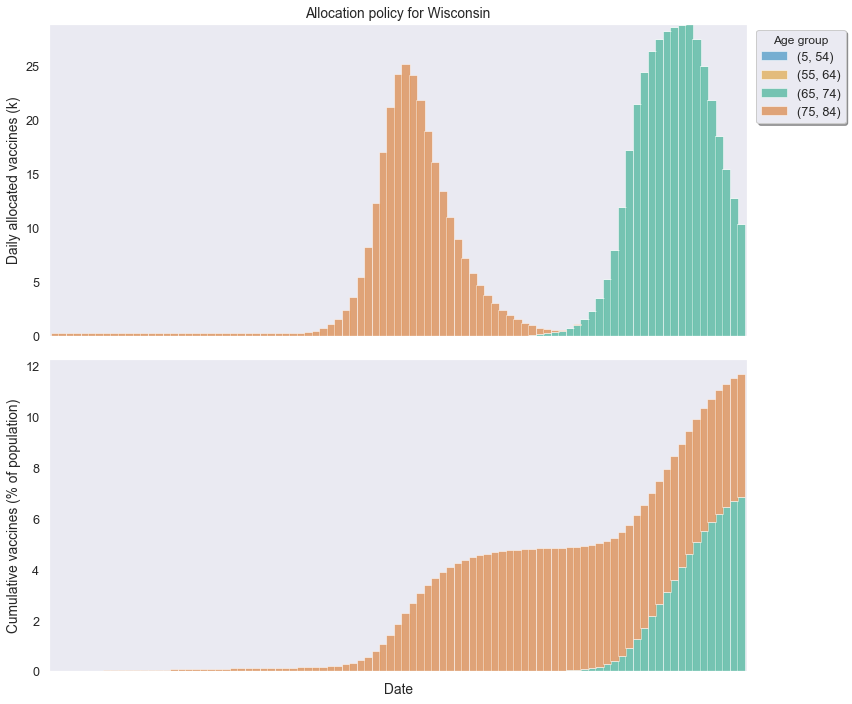

In [521]:
plot_policy_for_state("Wisconsin")

In [546]:
scatter_animation(
    solution=solution,
    model=model
)